<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q7 PyTorch (40 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

While you were able to derive manual back-propagation rules for sigmoid and fully-connected layers, wouldn't it be nice if someone did that for lots of useful primatives and made it fast and easy to use for general computation?  Meet [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). Since we have high-dimensional inputs (images) and low-dimensional outputs (a scalar loss), it turns out **forward mode AD** is very efficient. Popular autodiff packages include [pytorch](https://pytorch.org/) (Facebook), [tensorflow](https://www.tensorflow.org/) (Google), [autograd](https://github.com/HIPS/autograd) (Boston-area academics). Autograd provides its own replacement for numpy operators and is a drop-in replacement for numpy, except you can ask for gradients now. The other two are able to act as shim layers for [cuDNN](https://developer.nvidia.com/cudnn), an implementation of auto-diff made by Nvidia for use on their GPUs. Since GPUs are able to perform large amounts of math much faster than CPUs, this makes the former two packages very popular for researchers who train large networks. Tensorflow asks you to build a computational graph using its API, and then is able to pass data through that graph. PyTorch builds a dynamic graph and allows you to mix autograd functions with normal python code much more smoothly, so it is currently more popular among CMU students. 

We will use [pytorch](https://pytorch.org/) as a framework. Many computer vision projects use neural networks as a basic building block, so familiarity with one of these frameworks is a good skill to develop. Here, we basically replicate and slightly expand our handwritten character recognition networks, but do it in PyTorch instead of doing it ourselves. Feel free to use any tutorial you like, but we like [the offical one](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or [this tutorial](http://cs231n.stanford.edu/notebooks/pytorch_tutorial.ipynb) (in a jupyter notebook) or [these slides](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture08.pdf (starting from number 35).

**For this section, you're free to implement these however you like. All of the tasks required here are fairly small and don't require a GPU if you use small networks. Including 7.2.**

### Q7.1 Train a neural network in PyTorch

#### Q7.1.1 (10 Points Code+WriteUp)
 
Re-write and re-train your fully-connected network on NIST36 in PyTorch. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

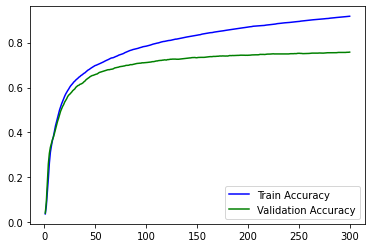

<Figure size 432x288 with 0 Axes>

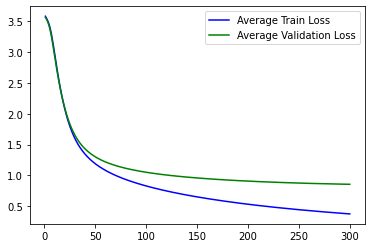

Validation accuracy:  0.7577777777777778
Max validation accuracy:  0.7577777777777778
Max validation accuracy index:  299


In [5]:
import numpy as np
import scipy.io
from ipynb.fs.defs.q2 import *
import torch
import torchvision.datasets
import matplotlib.pyplot as plt

# YOUR CODE HERE
train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_x, train_y = train_data['train_data'], train_data['train_labels']
valid_x, valid_y = valid_data['valid_data'], valid_data['valid_labels']
max_iters = 300
batch_size = 256
learning_rate = 0.1
input_dim = 1024
output_dim = 36
hidden_size = 64

model = torch.nn.Sequential(torch.nn.Linear(1024, 64), torch.nn.Sigmoid(), torch.nn.Linear(64, 36), torch.nn.Softmax(dim=1)).to(torch.float)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.NLLLoss()

batches = get_random_batches(train_x,train_y,batch_size)
batch_num = len(batches)

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for itr in range(max_iters):
    total_loss = 0
    total_acc = 0
    
    for xb,yb in batches:
        probs = model.forward(torch.tensor(xb).to(torch.float))
        loss, acc = compute_loss_and_acc(yb, probs.detach().numpy())
        total_loss += loss
        total_acc += acc
        
        pt_loss = loss_function(torch.log(probs), torch.argmax(torch.tensor(yb), dim=1))
        optimizer.zero_grad()
        pt_loss.backward()
        optimizer.step()
        
    acc = total_acc / len(batches)
    train_loss.append(total_loss / (batch_size * len(batches)))
    train_acc.append(acc)
    
    with torch.no_grad():
        probs = model.forward(torch.tensor(valid_x).to(torch.float))
    loss, acc = compute_loss_and_acc(valid_y, probs.numpy())
    valid_loss.append(loss / valid_y.shape[0])
    valid_acc.append(acc)
        
# run on validation set and report accuracy! should be above 75%
# YOUR CODE HERE
epochs = [i + 1 for i in range(max_iters)]
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy", c='b')
plt.plot(epochs, valid_acc, label="Validation Accuracy", c='g')
plt.legend()
plt.show()
plt.clf()
plt.figure()
plt.plot(epochs, train_loss, label="Average Train Loss", c='b')
plt.plot(epochs, valid_loss, label="Average Validation Loss", c='g')
plt.legend()
plt.show()

print('Validation accuracy: ', valid_acc[-1])
print('Max validation accuracy: ', np.max(valid_acc))
print('Max validation accuracy index: ', np.argmax(valid_acc))
valid_acc = valid_acc[-1]
        

#### Q7.1.2 (3 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on MNIST. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [ ]:
import numpy as np
import scipy.io
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from time import time

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")
mnist_train = MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
trainset_loader = DataLoader(mnist_train, batch_size=20, shuffle=True, num_workers=1)

mnist_test = MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
testset_loader = DataLoader(mnist_test, batch_size=20, shuffle=True, num_workers=1)

print("dataset size train, test")
print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)

# YOUR CODE HERE
max_iter = 1
learning_rate = 0.1
model = torch.nn.Sequential(torch.nn.Conv2d(1, 32, 3, stride=1), torch.nn.ReLU(), torch.nn.Conv2d(32, 32, 3, stride=1),
                         torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Conv2d(32, 64, 3, stride=1), torch.nn.ReLU(), 
                         torch.nn.Conv2d(64, 64, 3, stride=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Flatten(),
                         torch.nn.Linear(1024, 64), torch.nn.Sigmoid(), torch.nn.Linear(64, 10), torch.nn.Softmax(dim=1))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.NLLLoss()

valid_loss = []
valid_acc = []
train_loss = []
train_acc = []

all_features = mnist_train.train_data.unsqueeze(1).to(torch.float)
all_labels = mnist_train.train_labels

eval_loader = DataLoader(mnist_train, batch_size=100, shuffle=True, num_workers=1)

i = 0
for itr in range(max_iter):
    for train_features, train_labels in iter(trainset_loader):
        probs = model.forward(train_features)
        pt_loss = loss_function(torch.log(probs), train_labels)
        #print(np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), train_labels.numpy())) / train_features.size()[0])
        optimizer.zero_grad()
        pt_loss.backward()
        optimizer.step()
        if i % 100 == 0:
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(eval_loader):
                with torch.no_grad():
                    probs = model.forward(eval_features)
                pt_loss = loss_function(torch.log(probs), eval_labels)
                total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                total_loss += pt_loss.item()
                total += eval_features.size()[0]
                n += 1

            avg_loss = total_loss / n
            acc = total_correct / total
            train_loss.append(avg_loss)
            train_acc.append(acc)
            print(i, avg_loss, acc)
            
            total_loss = 0
            total_correct = 0
            total = 0
            n
            for eval_features, eval_labels in iter(testset_loader):
                with torch.no_grad():
                    probs = model.forward(eval_features)
                pt_loss = loss_function(torch.log(probs), eval_labels)
                total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                total_loss += pt_loss.item()
                total += eval_labels.size()[0]
                n += 1
            avg_loss = total_loss / n
            acc = total_correct / total
            valid_loss.append(avg_loss)
            valid_acc.append(acc)
            print(i, avg_loss, acc)
        i += 1

epochs = [i + 1 for i in range(len(train_acc))]
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy", c='b')
plt.plot(epochs, valid_acc, label="Validation Accuracy", c='g')
plt.legend()
plt.show()
plt.clf()
plt.figure()
plt.plot(epochs, train_loss, label="Average Train Loss", c='b')
plt.plot(epochs, valid_loss, label="Average Validation Loss", c='g')
plt.legend()
plt.show()

#### Q7.1.3 (2 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the included NIST36 dataset. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

device = cpu
Get dataset
itr: 00 	 loss: 3.615557 	 acc : 0.025484
0 3.6128053665161133 0.027777777777777776
itr: 100 	 loss: 3.584809 	 acc : 0.029855
100 3.586379051208496 0.027777777777777776
itr: 200 	 loss: 3.583976 	 acc : 0.029669
200 3.58557391166687 0.027777777777777776
itr: 300 	 loss: 3.583501 	 acc : 0.028832
300 3.5849342346191406 0.027777777777777776
itr: 400 	 loss: 3.580317 	 acc : 0.029483
400 3.5818355083465576 0.027777777777777776
itr: 500 	 loss: 3.562041 	 acc : 0.029855
500 3.563926935195923 0.027777777777777776
itr: 600 	 loss: 2.847223 	 acc : 0.374721
600 2.8604562282562256 0.3661111111111111
itr: 700 	 loss: 2.095071 	 acc : 0.583798
700 2.138399839401245 0.5572222222222222
itr: 800 	 loss: 1.460696 	 acc : 0.742188
800 1.5357192754745483 0.7002777777777778
itr: 900 	 loss: 1.062005 	 acc : 0.822731
900 1.1599791049957275 0.7741666666666667
itr: 1000 	 loss: 0.855695 	 acc : 0.851935
1000 0.9696508049964905 0.8061111111111111
itr: 1100 	 loss: 0.647295 	 acc :

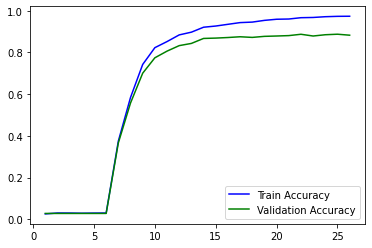

<Figure size 432x288 with 0 Axes>

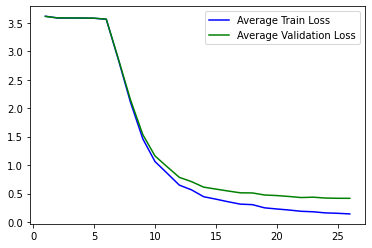

In [33]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from time import time
import matplotlib.pyplot as plt

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")
train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_x, train_y = train_data['train_data'].astype(np.float32), train_data['train_labels'].astype(np.int)
valid_x, valid_y = valid_data['valid_data'].astype(np.float32), valid_data['valid_labels'].astype(np.int)

# YOUR CODE HERE
batch_size = 128
learning_rate = 0.1
max_iters = 30
batches = get_random_batches(train_x,train_y,batch_size)
model = torch.nn.Sequential(torch.nn.Conv2d(1, 32, 3, stride=1), torch.nn.ReLU(), torch.nn.Conv2d(32, 32, 3, stride=1),
                         torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Conv2d(32, 64, 3, stride=1), torch.nn.ReLU(), 
                         torch.nn.Conv2d(64, 64, 3, stride=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Flatten(),
                         torch.nn.Linear(1600, 64), torch.nn.Sigmoid(), torch.nn.Linear(64, 36), torch.nn.Softmax(dim=1))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.NLLLoss()

i = 0
valid_loss = []
valid_acc = []
train_loss = []
train_acc = []
for itr in range(max_iters):
    total_loss = 0
    total_acc = 0
    
    for xb,yb in batches:
        probs = model.forward(torch.tensor(xb.reshape((-1, 1, 32, 32))))
        pt_loss = loss_function(torch.log(probs), torch.argmax(torch.tensor(yb), dim=1))
        optimizer.zero_grad()
        pt_loss.backward()
        optimizer.step()
        if i % 100 == 0:
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for xb, yb in batches:
                with torch.no_grad():
                    probs = model.forward(torch.tensor(xb.reshape((-1, 1, 32, 32))))
                pt_loss = loss_function(torch.log(probs), torch.argmax(torch.tensor(yb), dim=1))
                total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), np.argmax(yb, axis=1)))
                total_loss += pt_loss.item()
                total += yb.shape[0]
                n += 1

            avg_loss = total_loss / n
            acc = total_correct / total
            print("itr: {:02d} \t loss: {:.6f} \t acc : {:.6f}".format(i, avg_loss, acc))
            train_loss.append(avg_loss)
            train_acc.append(acc)
            
            with torch.no_grad():
                probs = model.forward(torch.tensor(valid_x.reshape((-1, 1, 32, 32))))
            pt_loss = loss_function(torch.log(probs), torch.argmax(torch.tensor(valid_y), dim=1))
            total_correct = np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), np.argmax(valid_y, axis=1)))
            total_loss = pt_loss.item()
            total = valid_y.shape[0]
            
            avg_loss = total_loss
            acc = total_correct / total
            valid_loss.append(avg_loss)
            valid_acc.append(acc)
            print(i, avg_loss, acc)
        i += 1
        
epochs = [i + 1 for i in range(len(train_acc))]
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy", c='b')
plt.plot(epochs, valid_acc, label="Validation Accuracy", c='g')
plt.legend()
plt.show()
plt.clf()
plt.figure()
plt.plot(epochs, train_loss, label="Average Train Loss", c='b')
plt.plot(epochs, valid_loss, label="Average Validation Loss", c='g')
plt.legend()
plt.show()

#### Q7.1.4 (15 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the EMNIST Balanced dataset  (available in *torchvision.datasets*, use *balanced* split) and evaluate it on the findLetters bounded boxes from the images folder. Find the accuracy on these bounded boxes.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

device = cpu
Get dataset
torch.Size([112800, 28, 28])
torch.Size([18800, 28, 28])
0 3.894307123642441 0.02127659574468085
0 3.8943080634486917 0.02127659574468085
100 3.844173442176048 0.03522163120567376
100 3.8441909705700517 0.03478723404255319
200 3.7023853401765754 0.096072695035461
200 3.7036741736794814 0.09632978723404255
300 3.462492046838111 0.18648936170212765
300 3.4654322205757606 0.1874468085106383
400 3.3558326786291515 0.28417553191489364
400 3.359409972113006 0.2828723404255319
500 3.275768497311477 0.34161347517730495
500 3.2795554975263115 0.34117021276595744
600 3.2099125157011317 0.38554078014184395
600 3.2138788691994282 0.38574468085106384
700 3.154372069007116 0.41925531914893616
700 3.1579115666499753 0.41925531914893616
800 3.0997414035154573 0.4435017730496454
800 3.1038671975233116 0.4405851063829787
900 3.0461231689926582 0.45557624113475176
900 3.0508722220959306 0.45324468085106384
1000 2.9970157862977778 0.4734042553191489
1000 3.002207794967963 0.471861

9600 0.9824618103762045 0.7784397163120568
9600 1.0068833106229094 0.7719148936170213
9700 0.9689720582137716 0.7807624113475178
9700 0.9941747385222895 0.7743617021276595
9800 0.9645362677092247 0.7788563829787234
9800 0.9919229877643845 0.7721808510638298
9900 0.96065154777351 0.7809219858156028
9900 0.986300162109388 0.7732446808510638
10000 0.9480315377631932 0.782322695035461
10000 0.9762294691841619 0.7760106382978723
10100 0.9414305705445033 0.7840425531914894
10100 0.9692568375545294 0.7768085106382979
10200 0.9378799467433429 0.783031914893617
10200 0.9648710260180389 0.7760106382978723
10300 0.9282450518498184 0.7850797872340426
10300 0.9565740428408798 0.7756382978723404
10400 0.9194378500923197 0.7858776595744681
10400 0.9469661268652702 0.7787765957446808
10500 0.9202895194080705 0.7848758865248227
10500 0.9487829090786629 0.776436170212766


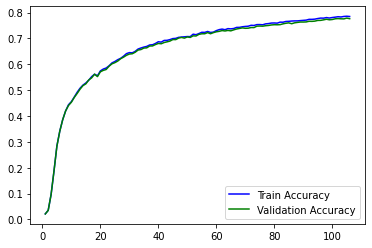

<Figure size 432x288 with 0 Axes>

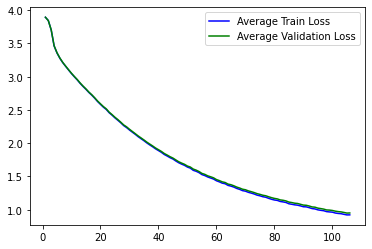

In [48]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from time import time

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")

EMNIST.url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
# Reference for transform function
# https://stackoverflow.com/a/54513835
transform=torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])
emnist_train = EMNIST(root="data", split='balanced', train=True, download=True, transform=transform)
trainset_loader = DataLoader(emnist_train, batch_size=64, shuffle=True, num_workers=1)

emnist_test = EMNIST(root="data", split='balanced', train=False, download=True, transform=transform)
testset_loader = DataLoader(emnist_test, batch_size=64, shuffle=True, num_workers=1)

# Ref: https://github.com/gaurav0651/emnist/blob/master/train_emnist.ipynb
label_map = ['0','1','2','3','4','5','6','7','8','9',
       'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
       'a','b','d','e','f','g','h','n','q','r','t']

print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)

# YOUR CODE HERE
max_iter = 6
learning_rate = 0.00005
model = torch.nn.Sequential(torch.nn.Conv2d(1, 32, 3, stride=1), torch.nn.ReLU(), torch.nn.Conv2d(32, 32, 3, stride=1),
                         torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Conv2d(32, 64, 3, stride=1), torch.nn.ReLU(), 
                         torch.nn.Conv2d(64, 64, 3, stride=1), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Flatten(),
                         torch.nn.Linear(1024, 64), torch.nn.Sigmoid(), torch.nn.Linear(64, len(label_map)), torch.nn.Softmax(dim=1))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.NLLLoss()

valid_loss = []
valid_acc = []
train_loss = []
train_acc = []

all_features = mnist_train.train_data.unsqueeze(1).to(torch.float)
all_labels = mnist_train.train_labels

eval_loader = DataLoader(emnist_train, batch_size=100, shuffle=True, num_workers=1)

i = 0
for itr in range(max_iter):
    for train_features, train_labels in iter(trainset_loader):
        probs = model.forward(train_features)
        pt_loss = loss_function(torch.log(probs), train_labels)
        #print(np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), train_labels.numpy())) / train_features.size()[0])
        optimizer.zero_grad()
        pt_loss.backward()
        optimizer.step()
        if i % 100 == 0:
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(eval_loader):
                with torch.no_grad():
                    probs = model.forward(eval_features)
                pt_loss = loss_function(torch.log(probs), eval_labels)
                total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                total_loss += pt_loss.item()
                total += eval_features.size()[0]
                n += 1

            avg_loss = total_loss / n
            acc = total_correct / total
            train_loss.append(avg_loss)
            train_acc.append(acc)
            print(i, avg_loss, acc)
            
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(testset_loader):
                with torch.no_grad():
                    probs = model.forward(eval_features)
                pt_loss = loss_function(torch.log(probs), eval_labels)
                total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                total_loss += pt_loss.item()
                total += eval_labels.size()[0]
                n += 1
            avg_loss = total_loss / n
            acc = total_correct / total
            valid_loss.append(avg_loss)
            valid_acc.append(acc)
            print(i, avg_loss, acc)
        i += 1

emnist_model = model
epochs = [i + 1 for i in range(len(train_acc))]
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy", c='b')
plt.plot(epochs, valid_acc, label="Validation Accuracy", c='g')
plt.legend()
plt.show()
plt.clf()
plt.figure()
plt.plot(epochs, train_loss, label="Average Train Loss", c='b')
plt.plot(epochs, valid_loss, label="Average Validation Loss", c='g')
plt.legend()
plt.show()

ipynb.fs.defs.q4:63: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


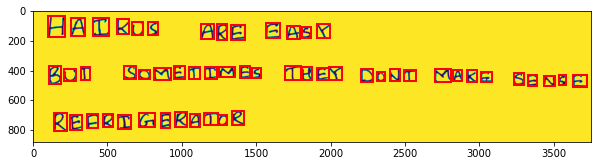

ipynb.fs.defs.q4:63: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


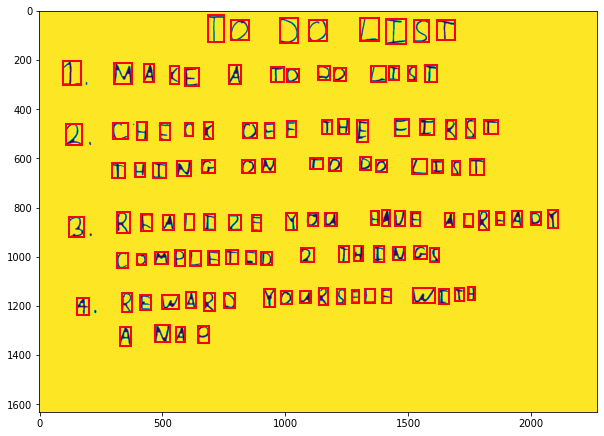

ipynb.fs.defs.q4:63: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


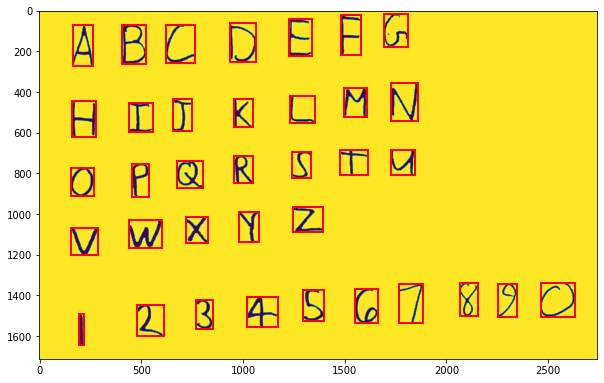

ipynb.fs.defs.q4:63: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


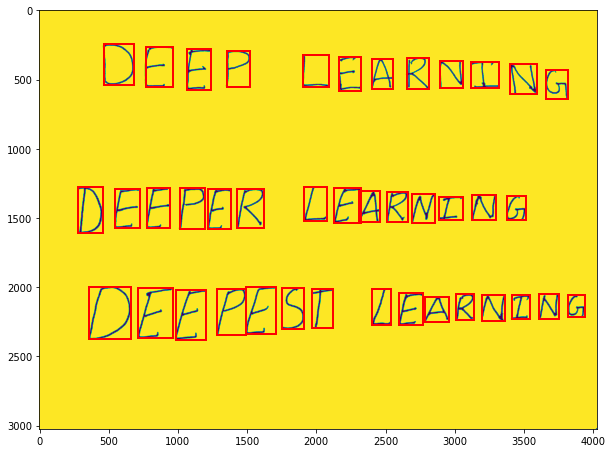

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches
import sklearn.cluster
import skimage.io
import skimage
import os

from ipynb.fs.defs.q4 import *

# do not include any more libraries here!
# no opencv, no sklearn, etc!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

def get(x):
    return(x[0])

def get2(x):
    return(x[1])

def get3(x):
    return(x[1][1])

img_cropped_images = []

for img in os.listdir('images'):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images',img)))
    bboxes, bw = findLetters(im1)

    plt.figure(figsize=(10,10))
    plt.imshow(bw)
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox
        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.show()
    # find the rows using..RANSAC, counting, clustering, etc.
    # YOUR CODE HERE
    cluster_model = sklearn.cluster.MeanShift(bandwidth=100)
    y_vals = bboxes[:, 2].reshape((-1, 1))
    cluster_model.fit(y_vals)
    labels = cluster_model.labels_
    centers = sorted([(c, i) for i, c in enumerate(cluster_model.cluster_centers_)], key=get)
    bbox_array = [[] for i in range(len(centers))]
    for i, cluster in enumerate(labels):
        bbox_array[cluster].append(bboxes[i])
    sorted_bbox_array = [bbox_array[i] for c, i in centers]
    sorted_bbox_array = [sorted(array, key=get2) for array in sorted_bbox_array]
    
    # crop the bounding boxes
    # note.. before you flatten, transpose the image (that's how the dataset is!)
    # consider doing a square crop, and even using np.pad() to get your images looking more like the dataset
    # YOUR CODE HERE
    cropped_images = []
    for row in sorted_bbox_array:
        cropped_images.append([])
        for i, bbox in enumerate(row):
            dy = (bbox[2] - bbox[0]) // 2
            dx = (bbox[3] - bbox[1]) // 2
            center_y = bbox[0] + dy
            center_x = bbox[1] + dx
            max_d = max(dy, dx)
            if i == 0:
                square_crop = bw[center_y - max_d:center_y + max_d, center_x - max_d:min(center_x + max_d, row[i+1][1])]
            elif i == len(row) - 1:
                square_crop = bw[center_y - max_d:center_y + max_d, max(center_x - max_d, row[i-1][3]):center_x + max_d]
            else:
                square_crop = bw[center_y - max_d:center_y + max_d, max(center_x - max_d, row[i-1][3]):min(center_x + max_d, row[i+1][1])]
            padded_image = np.pad(square_crop, pad_width=max_d // 4, constant_values=1)
            # plt.imshow(square_crop)
            # plt.show()
            resized_image = skimage.transform.resize(padded_image * 1.0, (28, 28))
            # plt.imshow(resized_image)
            # plt.show()
            cropped_images[-1].append(resized_image)
            
    img_cropped_images.append(cropped_images)

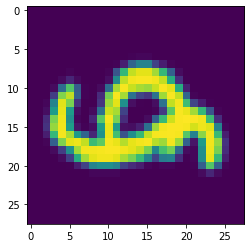

Result: H


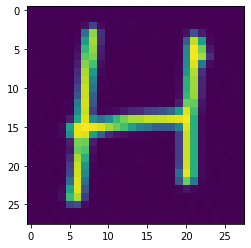

Result: n


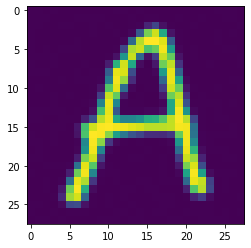

Result: P


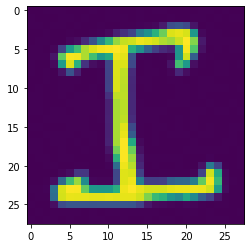

Result: K


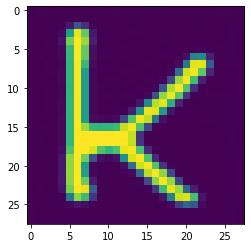

Result: U


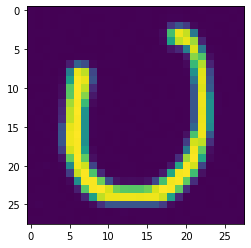

Result: f


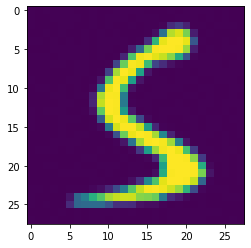

Result: A


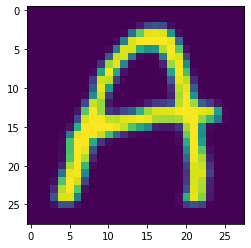

Result: K


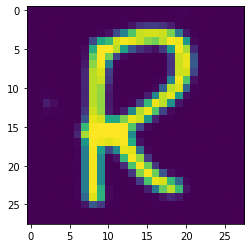

Result: B


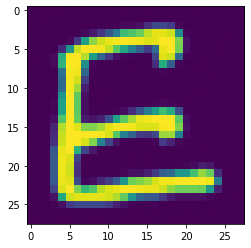

Result: G


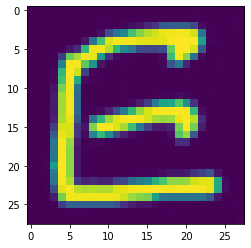

Result: A


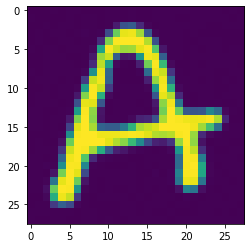

Result: g


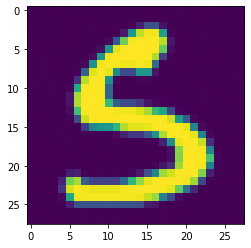

Result: Y


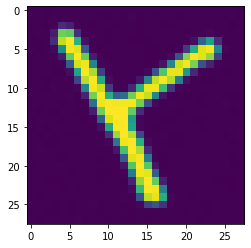

Result: H


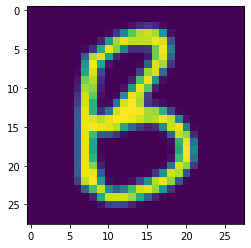

Result: W


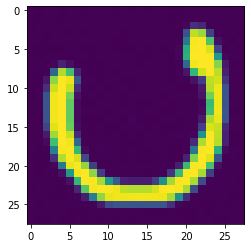

Result: T


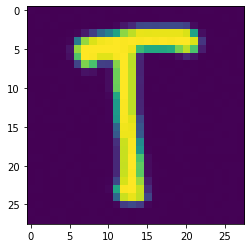

Result: S


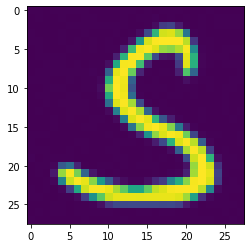

Result: O


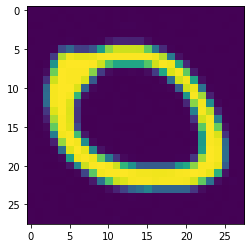

Result: M


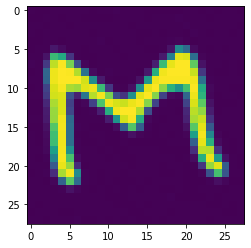

Result: B


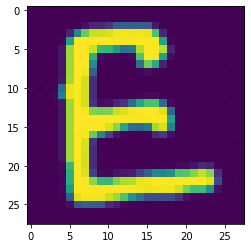

Result: T


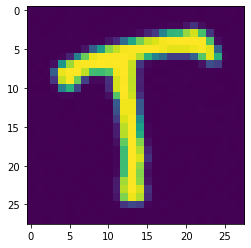

Result: 8


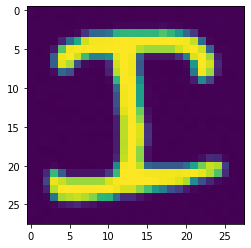

Result: M


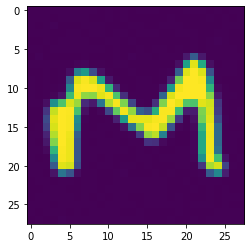

Result: B


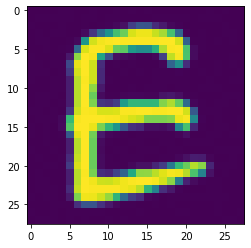

Result: S


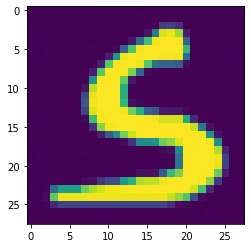

Result: T


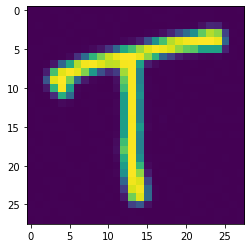

Result: n


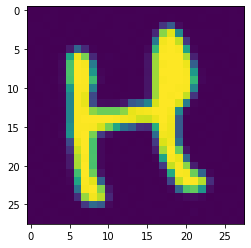

Result: B


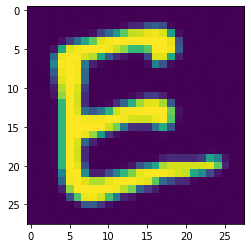

Result: Y


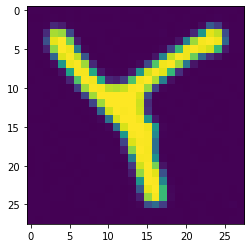

Result: 0


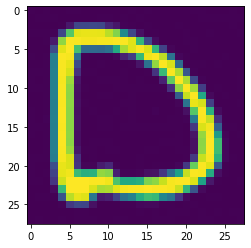

Result: 0


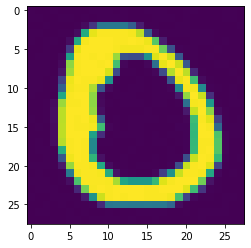

Result: N


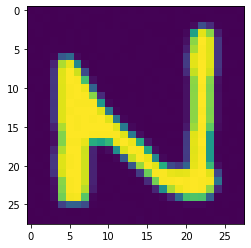

Result: T


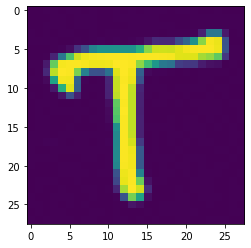

Result: M


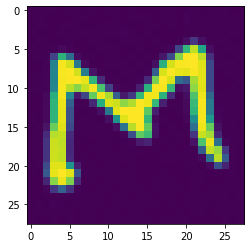

Result: A


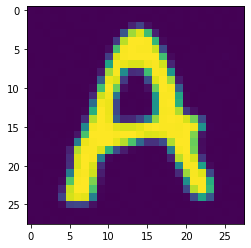

Result: K


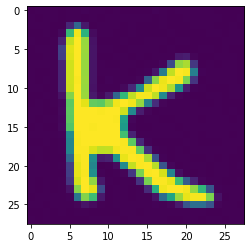

Result: G


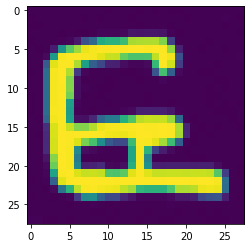

Result: g


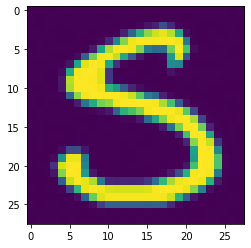

Result: B


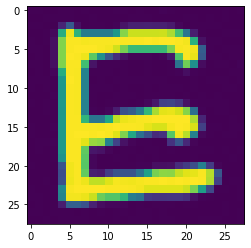

Result: N


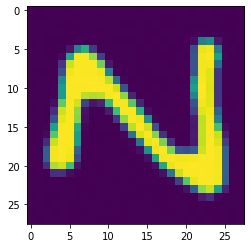

Result: G


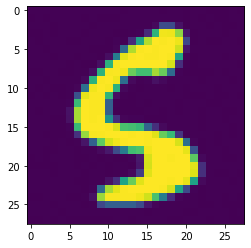

Result: G


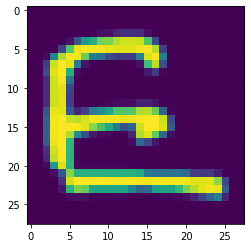

Result: K


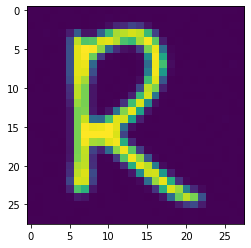

Result: 8


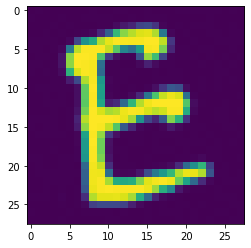

Result: f


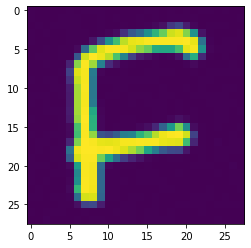

Result: q


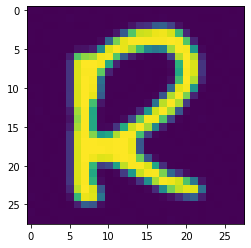

Result: 8


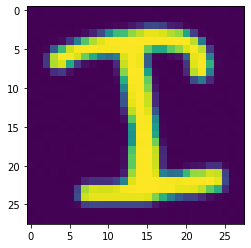

Result: A


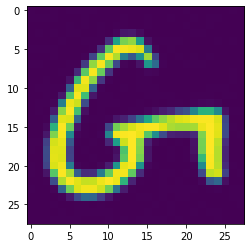

Result: E


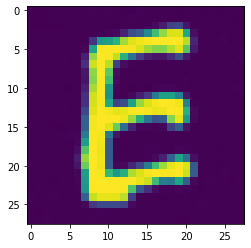

Result: K


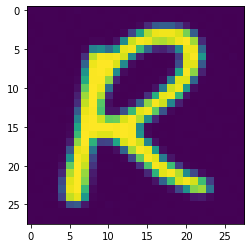

Result: A


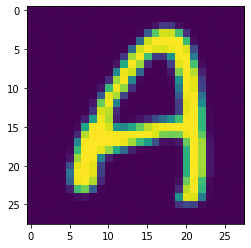

Result: T


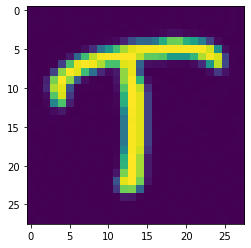

Result: U


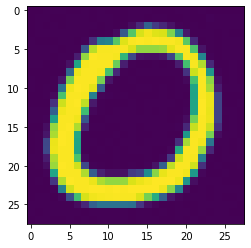

Result: K


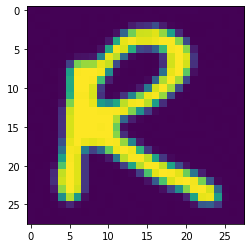

Result: P


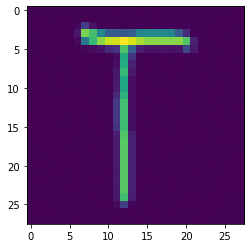

Result: D


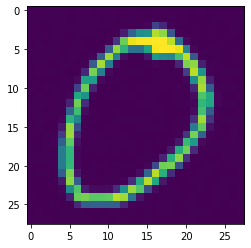

Result: n


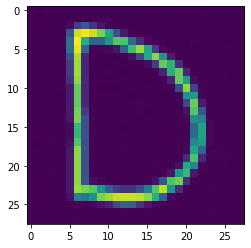

Result: M


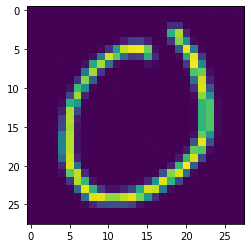

Result: r


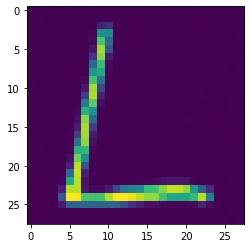

Result: R


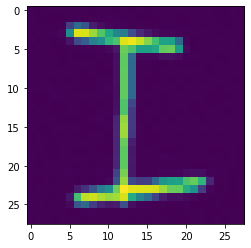

Result: 8


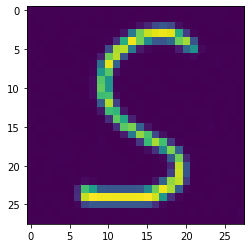

Result: T


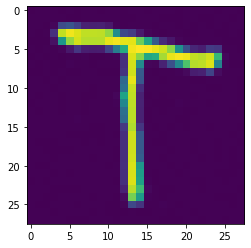

Result: I


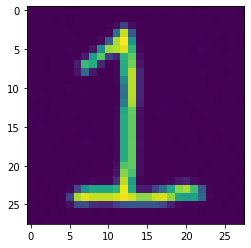

Result: N


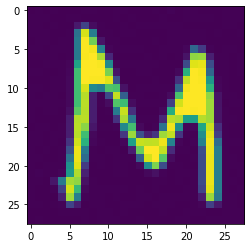

Result: t


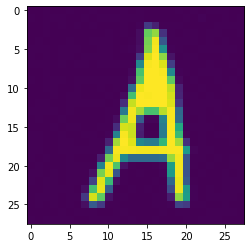

Result: R


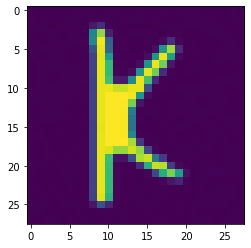

Result: K


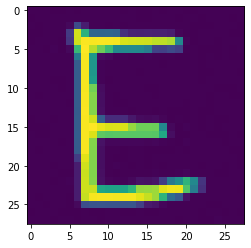

Result: A


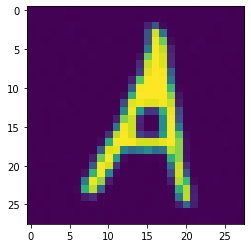

Result: F


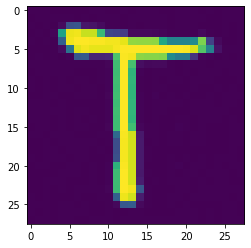

Result: n


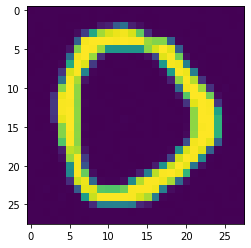

Result: U


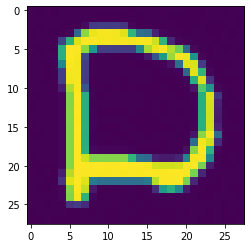

Result: N


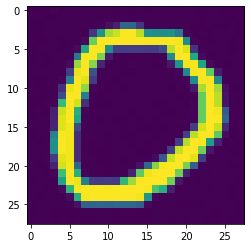

Result: K


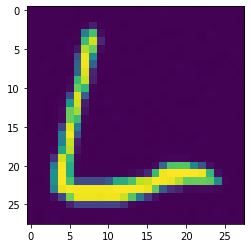

Result: T


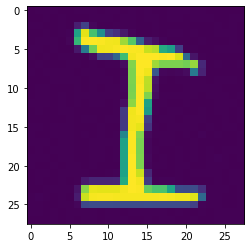

Result: S


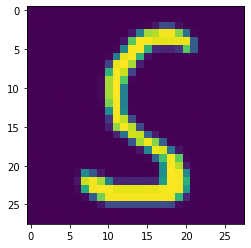

Result: T


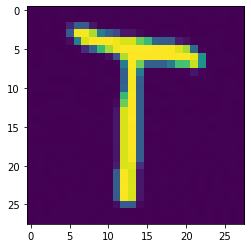

Result: d


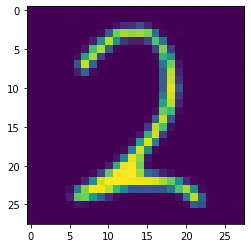

Result: W


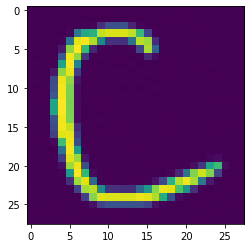

Result: H


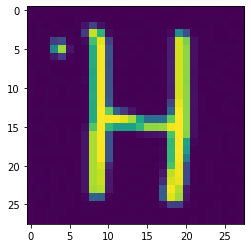

Result: P


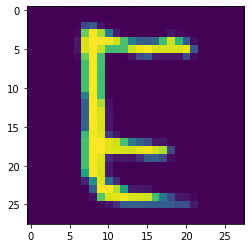

Result: r


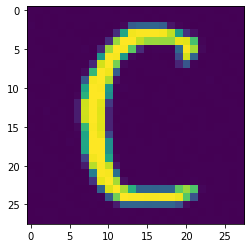

Result: r


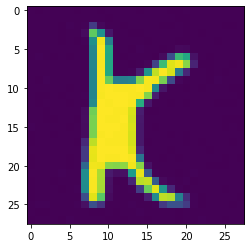

Result: n


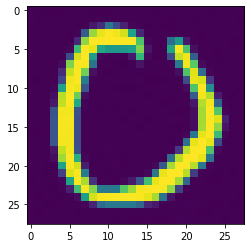

Result: F


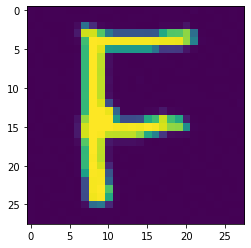

Result: P


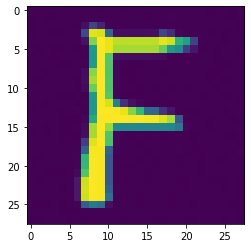

Result: Y


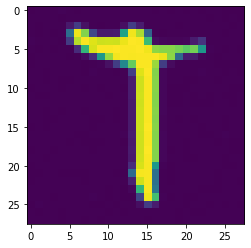

Result: H


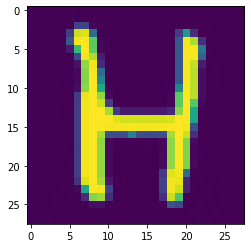

Result: E


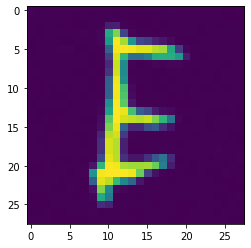

Result: F


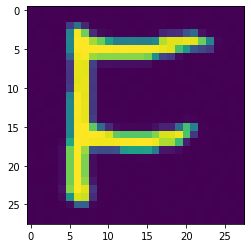

Result: T


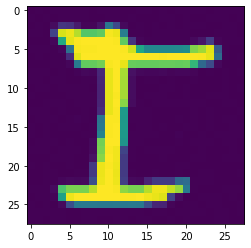

Result: R


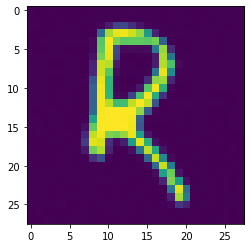

Result: 8


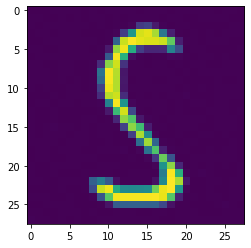

Result: F


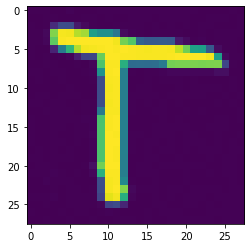

Result: T


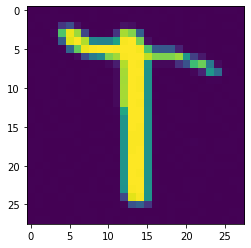

Result: H


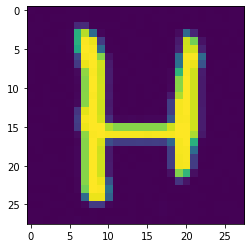

Result: P


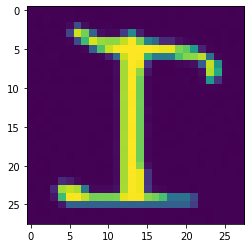

Result: N


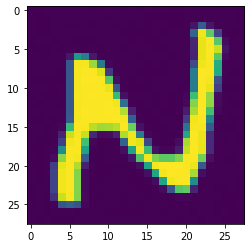

Result: G


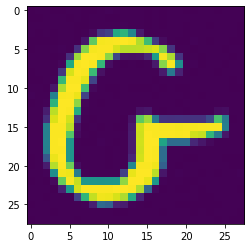

Result: n


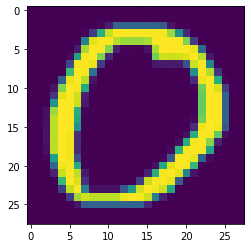

Result: N


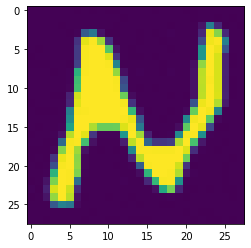

Result: T


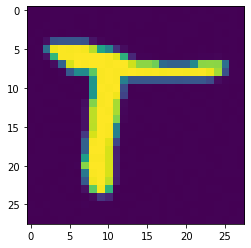

Result: n


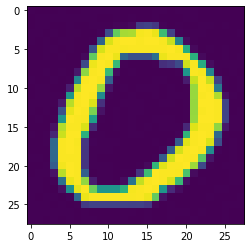

Result: D


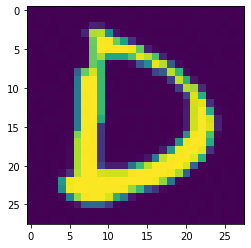

Result: n


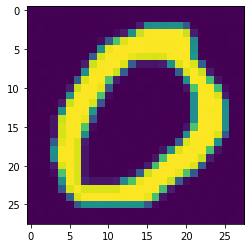

Result: R


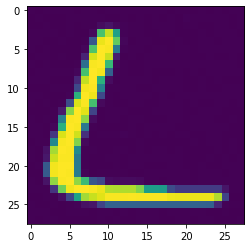

Result: E


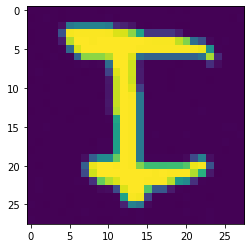

Result: 8


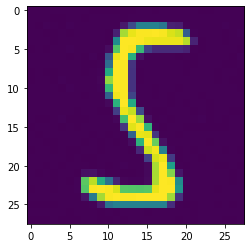

Result: P


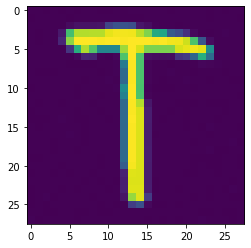

Result: B


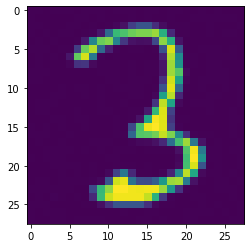

Result: K


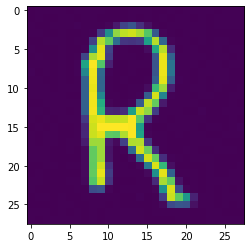

Result: P


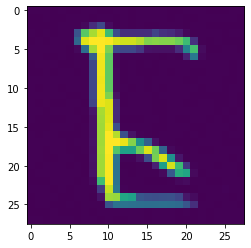

Result: A


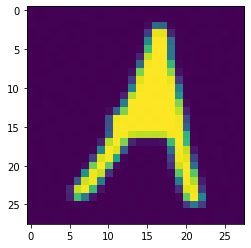

Result: r


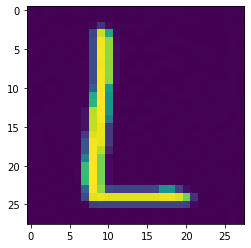

Result: F


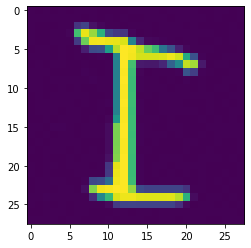

Result: 1


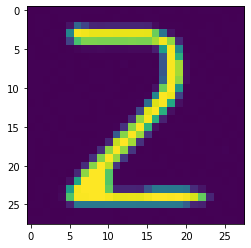

Result: P


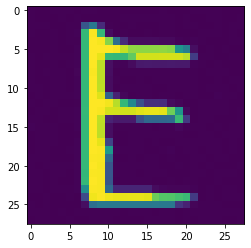

Result: Y


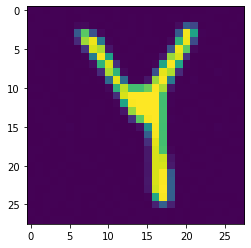

Result: n


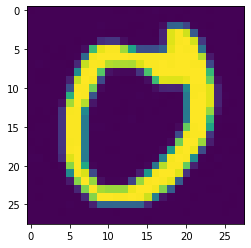

Result: U


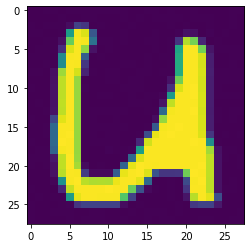

Result: H


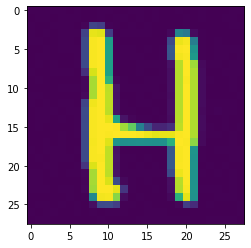

Result: A


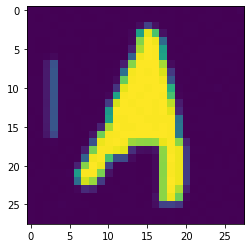

Result: U


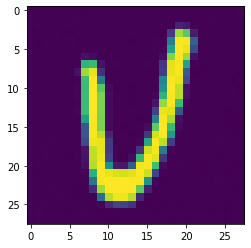

Result: F


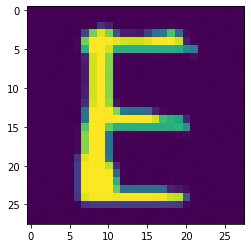

Result: h


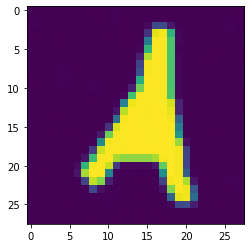

Result: K


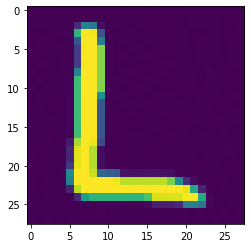

Result: K


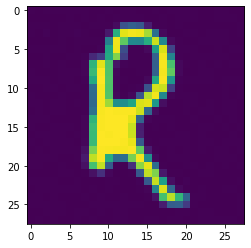

Result: F


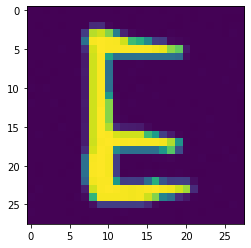

Result: A


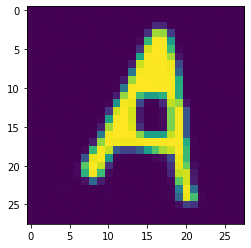

Result: D


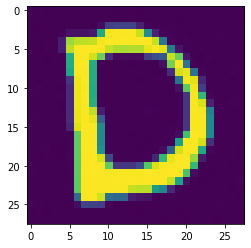

Result: Y


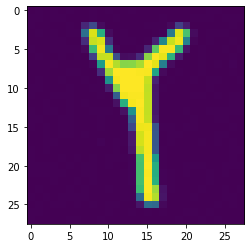

Result: r


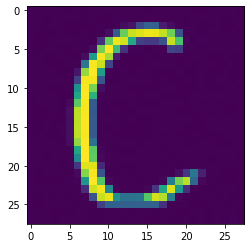

Result: n


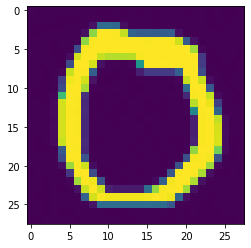

Result: M


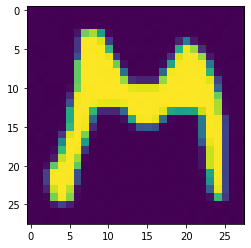

Result: P


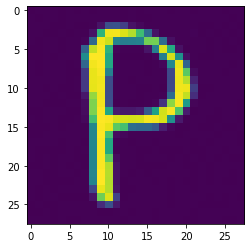

Result: r


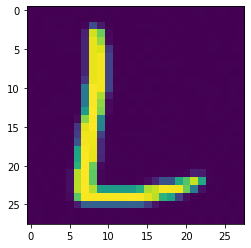

Result: F


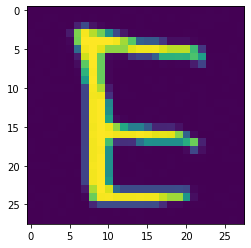

Result: T


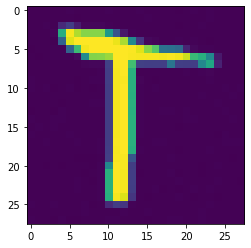

Result: E


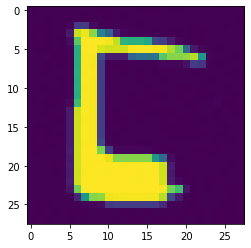

Result: n


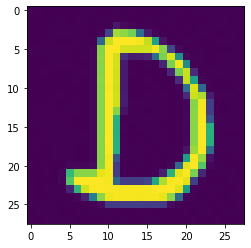

Result: 2


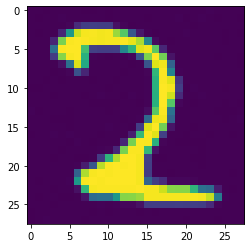

Result: T


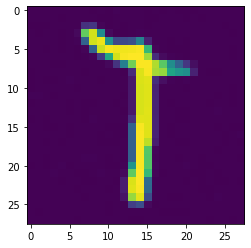

Result: H


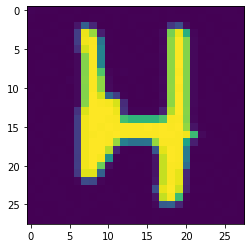

Result: L


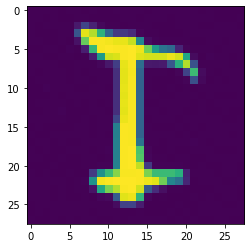

Result: N


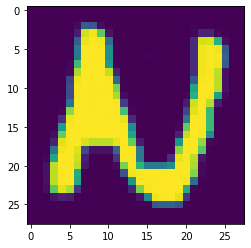

Result: G


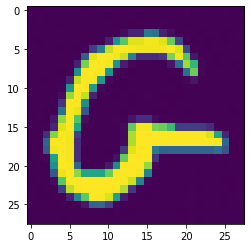

Result: R


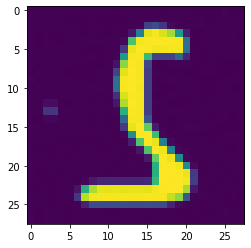

Result: t


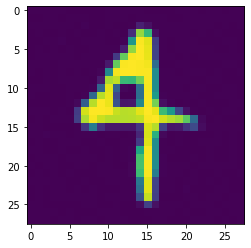

Result: K


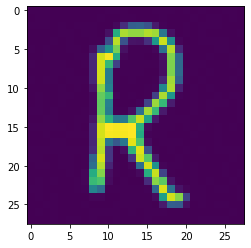

Result: P


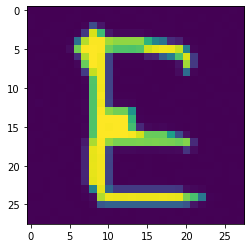

Result: W


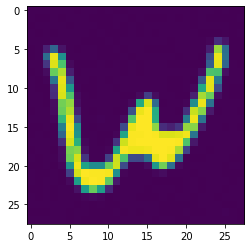

Result: A


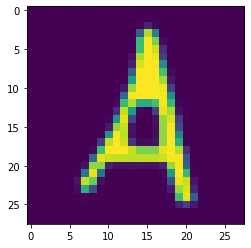

Result: K


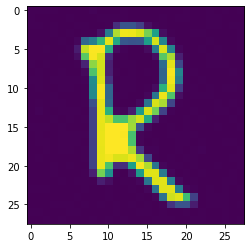

Result: n


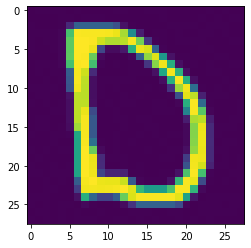

Result: Y


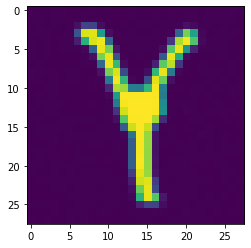

Result: n


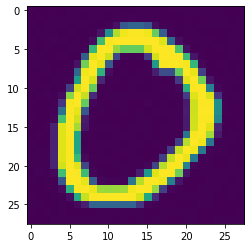

Result: U


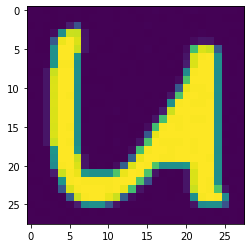

Result: K


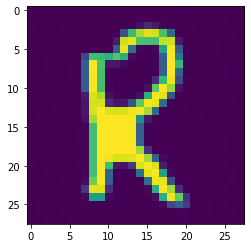

Result: Q


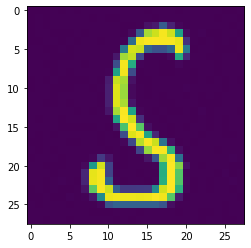

Result: F


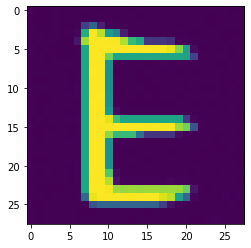

Result: r


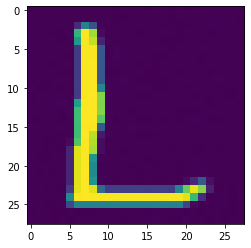

Result: P


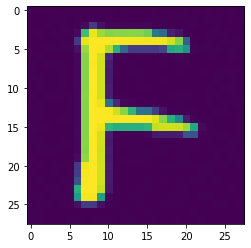

Result: W


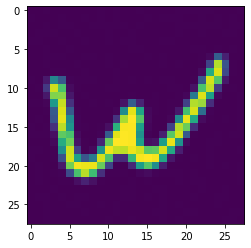

Result: P


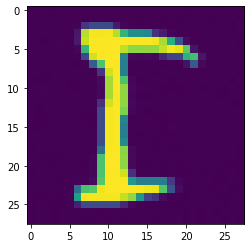

Result: T


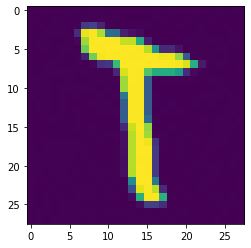

Result: H


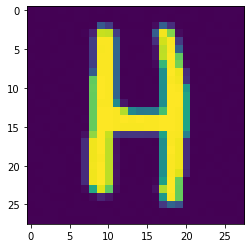

Result: A


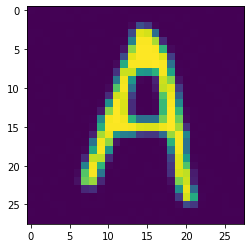

Result: N


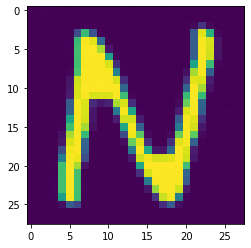

Result: A


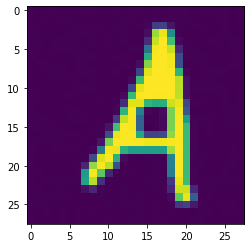

Result: H


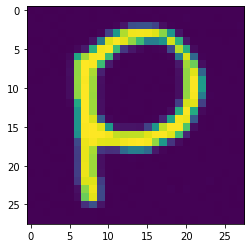

Result: A


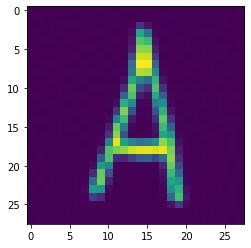

Result: H


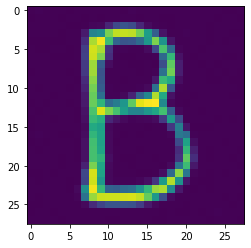

Result: A


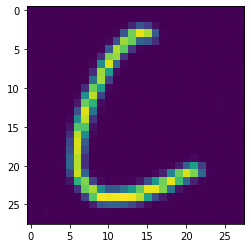

Result: n


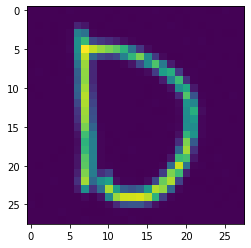

Result: P


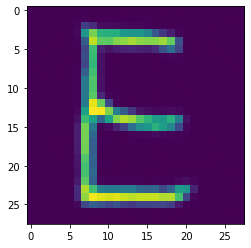

Result: P


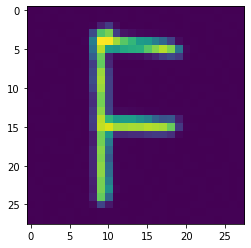

Result: G


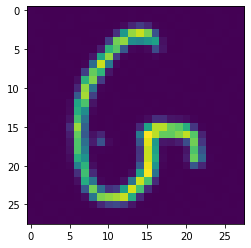

Result: H


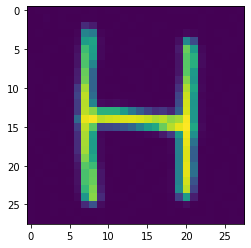

Result: f


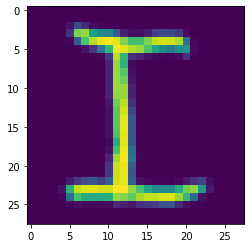

Result: T


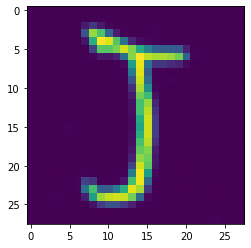

Result: K


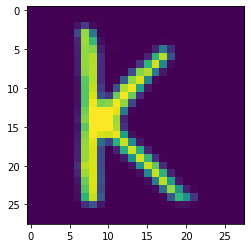

Result: U


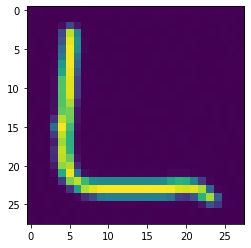

Result: M


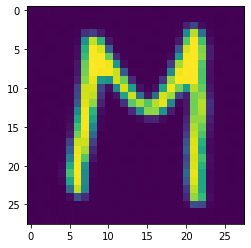

Result: N


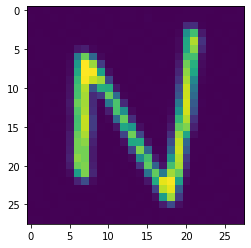

Result: n


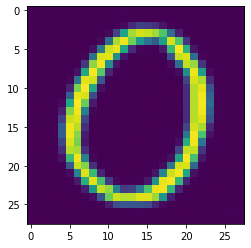

Result: P


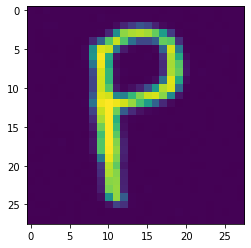

Result: a


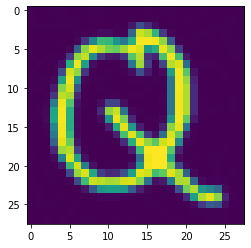

Result: K


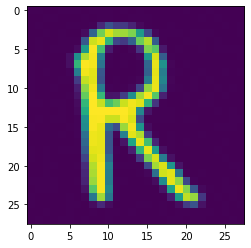

Result: 5


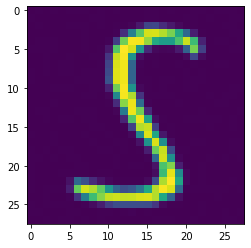

Result: T


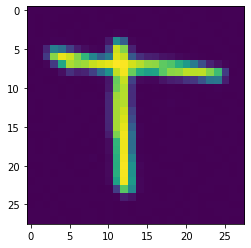

Result: M


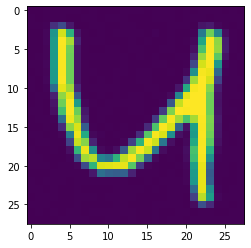

Result: V


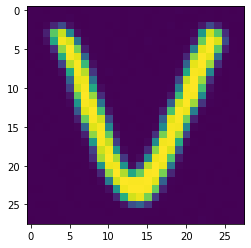

Result: W


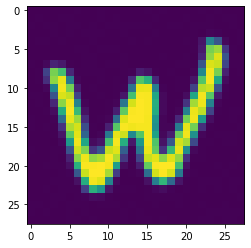

Result: X


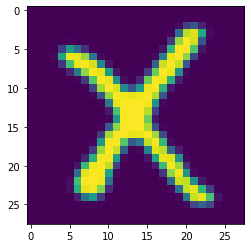

Result: Y


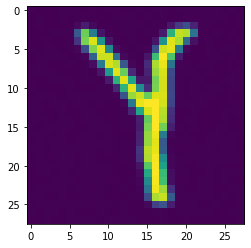

Result: Z


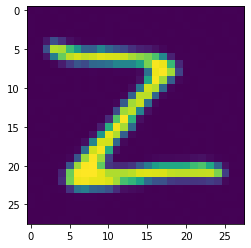

Result: L


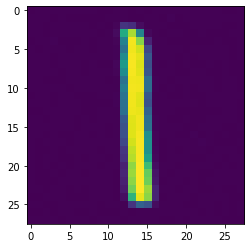

Result: L


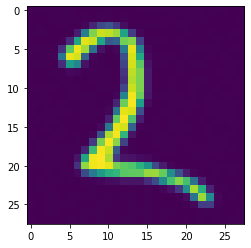

Result: 3


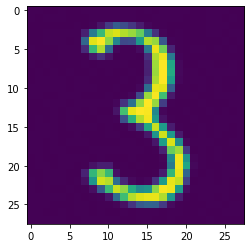

Result: M


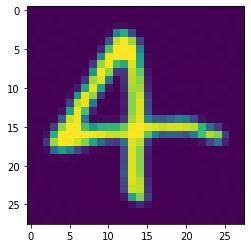

Result: S


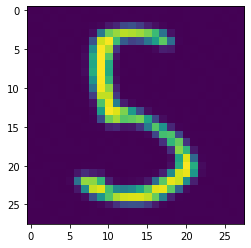

Result: h


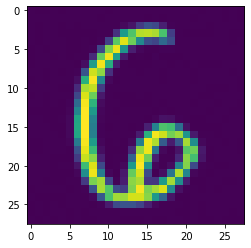

Result: 7


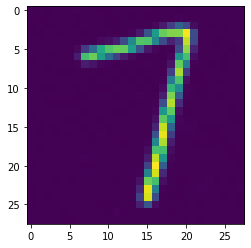

Result: 8


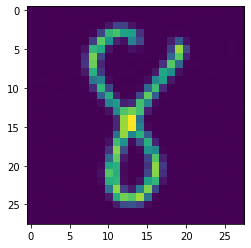

Result: 4


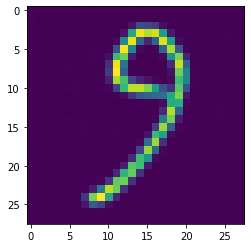

Result: n


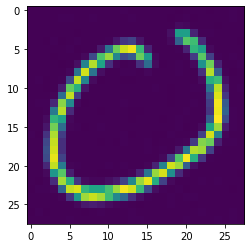

Result: n


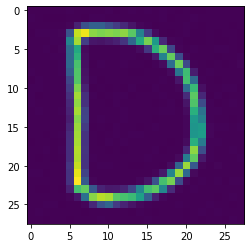

Result: H


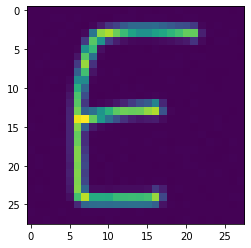

Result: B


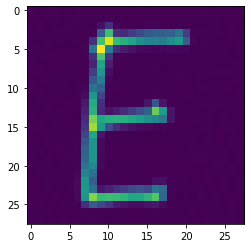

Result: P


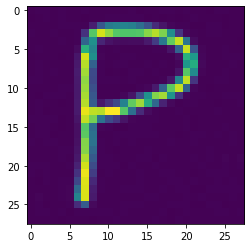

Result: W


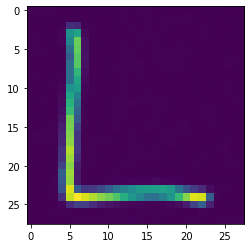

Result: B


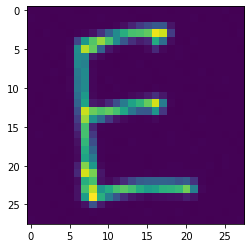

Result: A


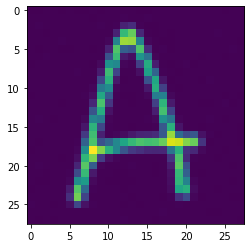

Result: K


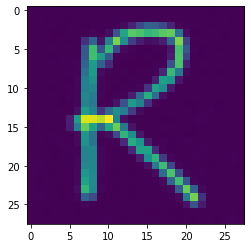

Result: N


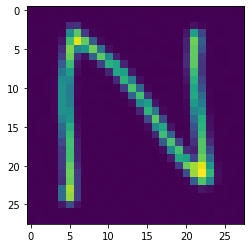

Result: h


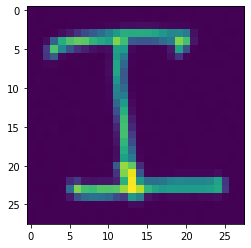

Result: N


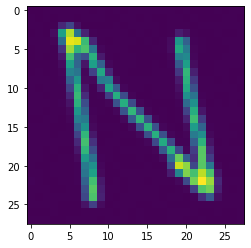

Result: 6


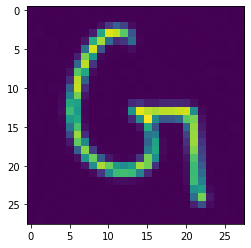

Result: A


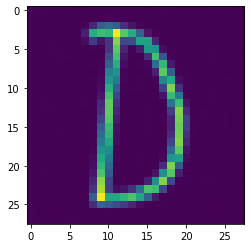

Result: B


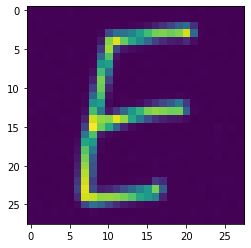

Result: P


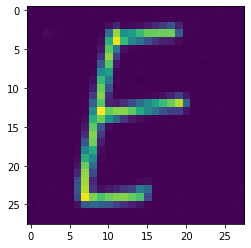

Result: P


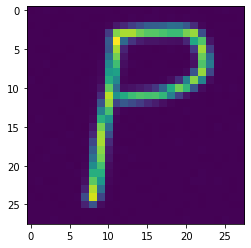

Result: H


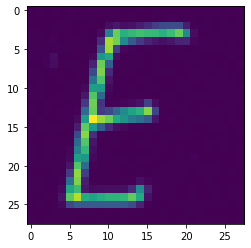

Result: K


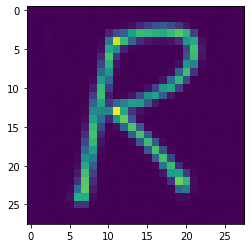

Result: n


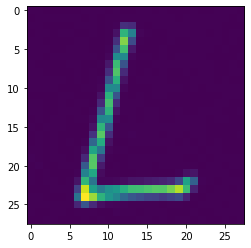

Result: 8


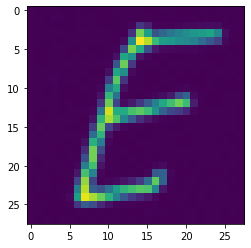

Result: a


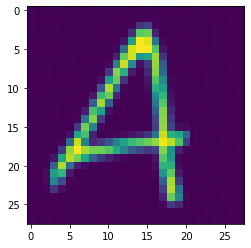

Result: K


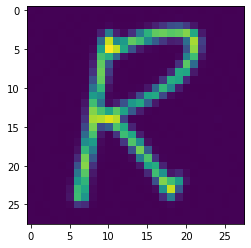

Result: N


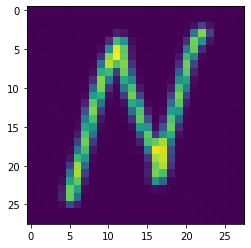

Result: R


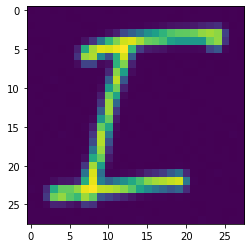

Result: N


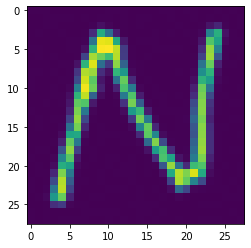

Result: G


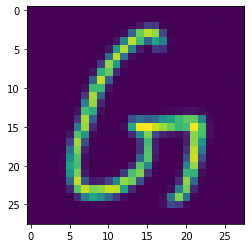

Result: D


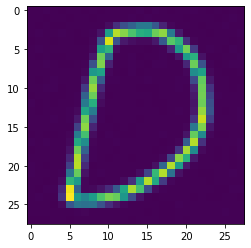

Result: M


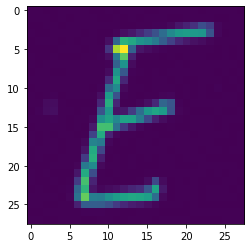

Result: M


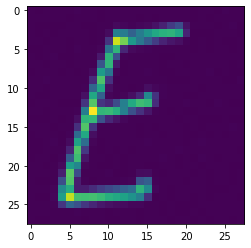

Result: P


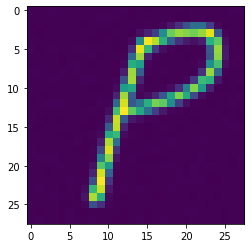

Result: A


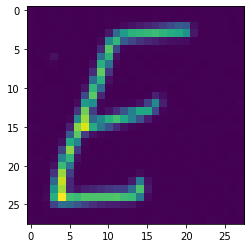

Result: 4


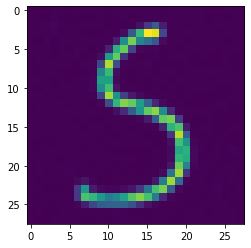

Result: M


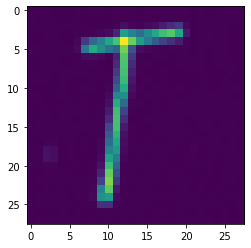

Result: L


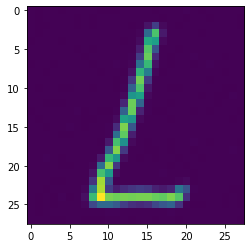

Result: f


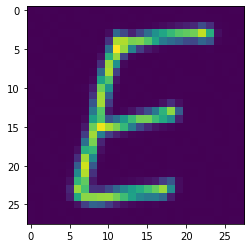

Result: A


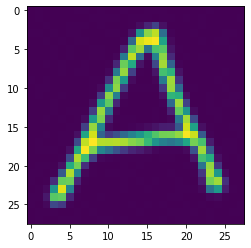

Result: K


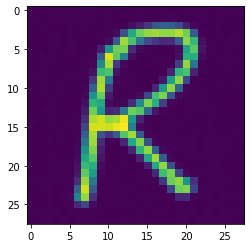

Result: N


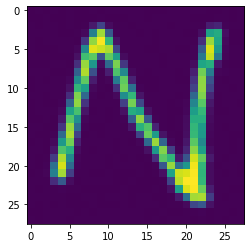

Result: 1


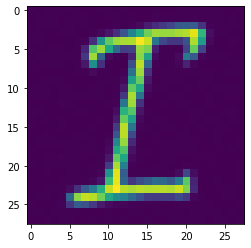

Result: N


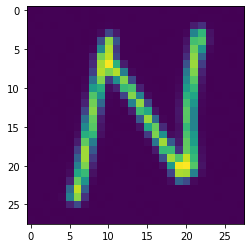

Result: G


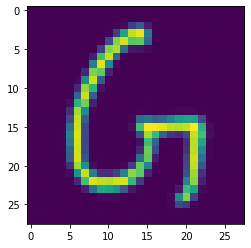

In [80]:
train_mean = np.mean(trainset_loader.dataset.data.numpy(), axis=0)
train_std = np.std(testset_loader.dataset.data.numpy(), axis=0)
#print(train_mean, train_std)

model = emnist_model

for k, cropped_images in enumerate(img_cropped_images):    
    all_images = -1 * np.array(np.concatenate(cropped_images))
    all_images += np.random.normal(loc=0.0, scale=0.0005, size=all_images.shape)
    
    batch_mean = np.mean(all_images, axis=0)
    batch_std = np.std(all_images, axis=0)
    
    for row in cropped_images:
        for image in row:
            image = image * -1
            image += np.random.normal(loc=0.0, scale=0.0005, size=image.shape)
            normalized_image = (image - batch_mean) / batch_std * train_std + train_mean

            torch_image = torch.tensor(normalized_image).reshape((1, 1, 28, 28))

            with torch.no_grad():
                output = model.forward(torch_image.to(torch.float))
                output = label_map[np.argmax(output)]
                print("Result: {}".format(output))
                plt.imshow(normalized_image)
                plt.imshow(image)
                plt.show()


My accuracy on all the letters in all the images was 53% but there was a lot of variance in the accuracy per image. The best image had accuracy 72% while the worst had 35% accuracy.

### Q7.2 Fine Tuning

#### Q7.2.1 (10 Points Code+WriteUp)
 
Fine-tune a single layer classifier using pytorch on the [flowers 17](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) (or [flowers 102](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)!) dataset using [squeezenet1\_1](https://pytorch.org/docs/stable/torchvision/models.html), as well as an architecture you've designed yourself (*3 conv layers, followed 2 fc layers, it's standard [slide 6](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture09.pdf)*) and trained from scratch. How do they compare? 
    
We include a script in `scripts/` to fetch the flowers dataset and extract it in a way that [PyTorch ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) can consume it, see [an example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision), from **data/oxford-flowers17**. You should look at how SqueezeNet is [defined](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py), and just replace the classifier layer. There exists a pretty good example for [fine-tuning](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) in PyTorch.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [4]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from time import time

Datasets Formed
Dataloaders Formed


Using cache found in /home/thomaswei/.cache/torch/hub/pytorch_vision_v0.10.0


0 6.862134239890358 0.09558823529411764
0 7.117510080337524 0.1
5 13.1279804056341 0.058823529411764705
5 13.376075267791748 0.058823529411764705
10 8.897814360531894 0.16176470588235295
10 8.641996304194132 0.16176470588235295
15 6.1645028374411845 0.09411764705882353
15 6.135513385136922 0.09411764705882353
20 4.830698013305664 0.16911764705882354
20 5.089385112126668 0.14411764705882352
25 4.268115412105214 0.35
25 4.365259687105815 0.3058823529411765
30 1.9734607067975132 0.45294117647058824
30 2.1328901052474976 0.3735294117647059
35 1.669539668343284 0.4676470588235294
35 1.8512083490689595 0.39705882352941174
40 1.6679491346532649 0.5632352941176471
40 1.8619517087936401 0.49117647058823527
45 1.408138166774403 0.5352941176470588
45 1.611412803332011 0.4323529411764706
50 1.207449658350511 0.6411764705882353
50 1.4129680395126343 0.5617647058823529
55 1.0114231759851628 0.6808823529411765
55 1.2834143837292988 0.6264705882352941
60 0.9852676716717806 0.7014705882352941
60 1.1362

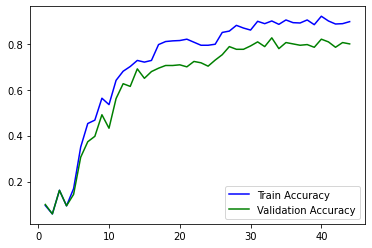

<Figure size 432x288 with 0 Axes>

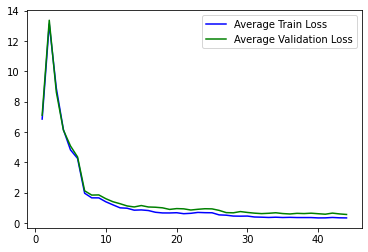

In [12]:
# Code for fine-tune squeezenet1_1
# YOUR CODE HERE

from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', pretrained=True)

max_iter = 20
learning_rate = 0.0005
classifier = torch.nn.Sequential(torch.nn.Linear(1000, 17))
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

train_dataset = torchvision.datasets.ImageFolder(root='data/oxford-flowers17/train', transform=preprocess)
test_dataset = torchvision.datasets.ImageFolder(root='data/oxford-flowers17/test', transform=preprocess)
print("Datasets Formed")

trainset_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
eval_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
testset_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=1)
print("Dataloaders Formed")

valid_loss = []
valid_acc = []
train_loss = []
train_acc = []

i = 0
for itr in range(max_iter):
    for train_features, train_labels in iter(trainset_loader):
        with torch.no_grad():
            features = pretrained_model.forward(train_features)
        probs = classifier.forward(features)
        pt_loss = loss_function(probs, train_labels)
        #print(np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), train_labels.numpy())) / train_features.size()[0])
        optimizer.zero_grad()
        pt_loss.backward()
        optimizer.step()
        if i % 5 == 0:
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(eval_loader):
                with torch.no_grad():
                    features = pretrained_model.forward(eval_features)
                    probs = classifier.forward(features)
                    pt_loss = loss_function(probs, eval_labels)
                    total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                    total_loss += pt_loss.item()
                    total += eval_features.size()[0]
                    n += 1

            avg_loss = total_loss / n
            acc = total_correct / total
            train_loss.append(avg_loss)
            train_acc.append(acc)
            print(i, avg_loss, acc)
            
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(testset_loader):
                with torch.no_grad():
                    features = pretrained_model.forward(eval_features)
                    probs = classifier.forward(features)
                    pt_loss = loss_function(probs, eval_labels)
                    total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                    total_loss += pt_loss.item()
                    total += eval_labels.size()[0]
                    n += 1
            avg_loss = total_loss / n
            acc = total_correct / total
            valid_loss.append(avg_loss)
            valid_acc.append(acc)
            print(i, avg_loss, acc)
        i += 1

epochs = [i + 1 for i in range(len(train_acc))]
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy", c='b')
plt.plot(epochs, valid_acc, label="Validation Accuracy", c='g')
plt.legend()
plt.show()
plt.clf()
plt.figure()
plt.plot(epochs, train_loss, label="Average Train Loss", c='b')
plt.plot(epochs, valid_loss, label="Average Validation Loss", c='g')
plt.legend()
plt.show()
    

0 2.823060165752064 0.10735294117647058
0 2.8273726304372153 0.09411764705882353
5 2.7260545167055996 0.175
5 2.7419493595759072 0.15
10 2.6302708062258633 0.2676470588235294
10 2.6734827359517417 0.21470588235294116
15 2.555576129393144 0.31323529411764706
15 2.614941954612732 0.21470588235294116
20 2.4963074163957075 0.29705882352941176
20 2.5827019611994424 0.23529411764705882
25 2.4402096271514893 0.3176470588235294
25 2.544737458229065 0.25588235294117645
30 2.394754561510953 0.36323529411764705
30 2.5047974586486816 0.26176470588235295
35 2.3515993031588467 0.40588235294117647
35 2.460916757583618 0.2735294117647059
40 2.3154149705713447 0.4588235294117647
40 2.453078349431356 0.2823529411764706
45 2.2790991393002598 0.40588235294117647
45 2.4292596181233725 0.27647058823529413
50 2.243058269674128 0.4235294117647059
50 2.3859209219614663 0.2647058823529412
55 2.2098558165810327 0.475
55 2.370614210764567 0.29411764705882354
60 2.173002243041992 0.513235294117647
60 2.36343447367

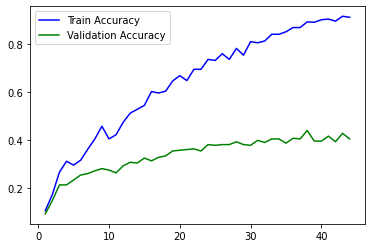

<Figure size 432x288 with 0 Axes>

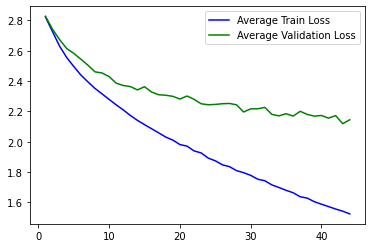

In [20]:
# Code for fine-tune the network you designed
# YOUR CODE HERE

model = torch.nn.Sequential(torch.nn.Conv2d(3, 6, 5, stride=1), torch.nn.ReLU(), 
                            torch.nn.MaxPool2d(2), torch.nn.Conv2d(6, 16, 5, stride=1), 
                            torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.Flatten(), 
                            torch.nn.Linear(44944, 64), torch.nn.Sigmoid(), torch.nn.Linear(64, 17))

max_iter = 20
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

valid_loss = []
valid_acc = []
train_loss = []
train_acc = []

i = 0
for itr in range(max_iter):
    for train_features, train_labels in iter(trainset_loader):
        probs = model.forward(train_features)
        pt_loss = loss_function(probs, train_labels)
        #print(np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), train_labels.numpy())) / train_features.size()[0])
        optimizer.zero_grad()
        pt_loss.backward()
        optimizer.step()
        if i % 5 == 0:
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(eval_loader):
                with torch.no_grad():
                    probs = model.forward(eval_features)
                    pt_loss = loss_function(probs, eval_labels)
                    total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                    total_loss += pt_loss.item()
                    total += eval_features.size()[0]
                    n += 1

            avg_loss = total_loss / n
            acc = total_correct / total
            train_loss.append(avg_loss)
            train_acc.append(acc)
            print(i, avg_loss, acc)
            
            total_loss = 0
            total_correct = 0
            total = 0
            n = 0
            for eval_features, eval_labels in iter(testset_loader):
                with torch.no_grad():
                    probs = model.forward(eval_features)
                    pt_loss = loss_function(probs, eval_labels)
                    total_correct += np.sum(np.equal(np.argmax(probs.detach().numpy(), axis=1), eval_labels.numpy()))
                    total_loss += pt_loss.item()
                    total += eval_labels.size()[0]
                    n += 1
            avg_loss = total_loss / n
            acc = total_correct / total
            valid_loss.append(avg_loss)
            valid_acc.append(acc)
            print(i, avg_loss, acc)
        i += 1

epochs = [i + 1 for i in range(len(train_acc))]
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy", c='b')
plt.plot(epochs, valid_acc, label="Validation Accuracy", c='g')
plt.legend()
plt.show()
plt.clf()
plt.figure()
plt.plot(epochs, train_loss, label="Average Train Loss", c='b')
plt.plot(epochs, valid_loss, label="Average Validation Loss", c='g')
plt.legend()
plt.show()